## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

starter code from https://courses.engr.illinois.edu/cs445/fa2023/projects/gradient/ComputationalPhotography_ProjectGradient.html

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

import utils

## Part 1 Toy Problem (20 pts)

In [3]:
def toy_reconstruct(img):
    im_h, im_w = img.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    num_eq = 1 + im_h * (im_w - 1) + im_w * (im_h - 1)

    A = scipy.sparse.lil_matrix((num_eq, im_h * im_w))
    b = np.zeros((num_eq))

    A[0, im2var[0, 0]] = 1
    b[0] = img[0, 0]

    e = 1
    for y in range(im_h):
        for x in range(im_w - 1):
            A[e, im2var[y, x + 1]] = 1
            A[e, im2var[y, x]] = -1
            b[e] = img[y, x + 1] - img[y, x]
            e += 1

    for y in range(im_h - 1):
        for x in range(im_w):
            A[e, im2var[y + 1, x]] = 1
            A[e, im2var[y, x]] = -1
            b[e] = img[y + 1, x] - img[y, x]
            e += 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0]
    return v.reshape(im_h, im_w)

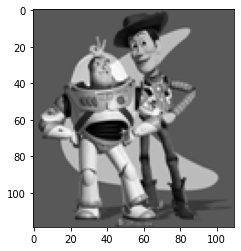

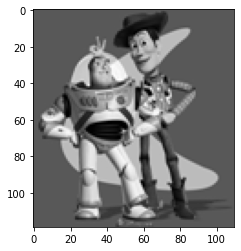

Max error is:  0.0010002051356813868


In [4]:
toy_img = cv2.cvtColor(cv2.imread('../samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

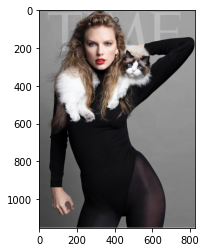

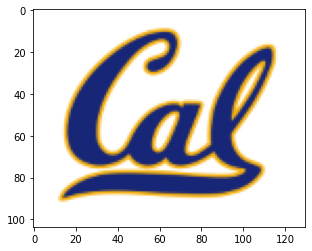

In [66]:
background_img = cv2.cvtColor(cv2.imread('../samples/taylor.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('../samples/cal.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.imshow(object_img)
plt.show()

use_interface = True  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2500) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


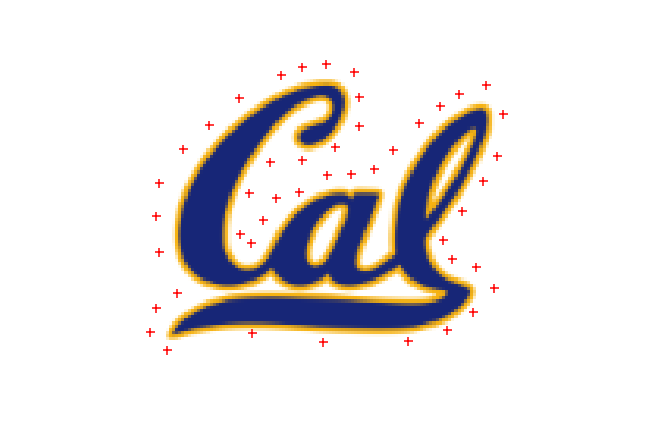

In [68]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = utils.specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

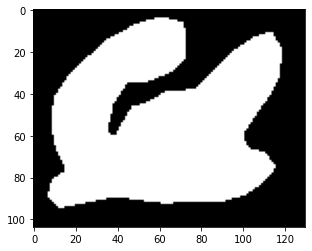

In [69]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = utils.get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


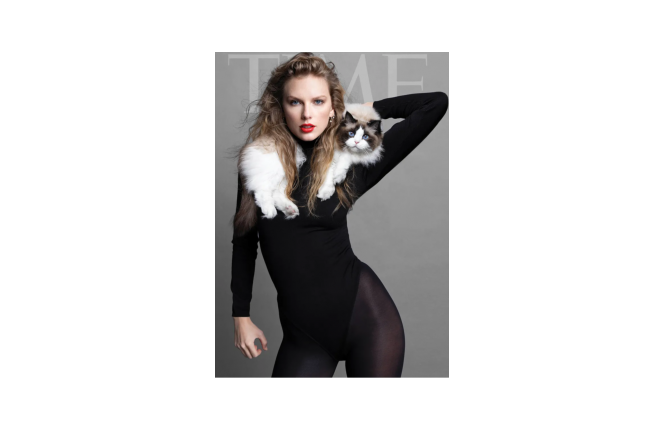

In [70]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = utils.specify_bottom_center(background_img)




<IPython.core.display.Javascript object>


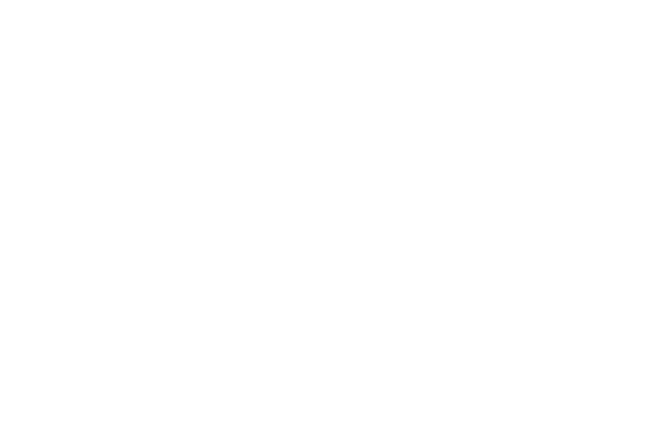

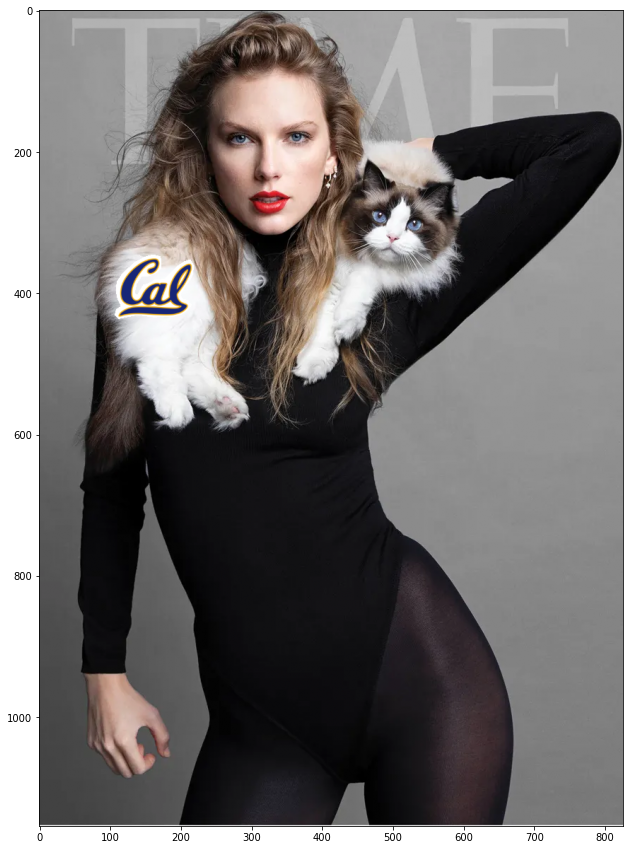

In [71]:
if use_interface:
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.figure(figsize=(15,15))
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

## Part 2 Poisson Blending (50 pts)

In [29]:

def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    assert(len(object_img.shape) == 2), "SINGLE CHANNEL IMAGE ONLY FOR THIS FUNCTION"

    result = bg_img.copy()
    b0, b1 = bg_ul

    im_h, im_w = object_mask.shape
    mask_flat = object_mask.flatten()
    mask_indices = np.where(mask_flat > 0)[0]
    num_values = np.sum(mask_flat)
    num_eq = 2 * num_values
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    A = scipy.sparse.lil_matrix((num_eq, im_h * im_w))
    b = np.zeros((num_eq))
    e = 0

    for i in mask_indices:
        y, x = np.unravel_index(i, (im_h, im_w))
        source = object_img[y, x]
        neighbors = [(y-1, x), (y, x+1)]

        for n in neighbors:
            yj, xj = n
            if object_mask[yj, xj]:
                A[e, im2var[yj, xj]] = -1
                A[e, im2var[y, x]] = 1
                b[e] = source - object_img[yj, xj]
            else:
                A[e, im2var[y, x]] = 1
                b[e] = source - object_img[yj, xj] + bg_img[b0 + yj, b1 + xj]
            e += 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0][mask_indices]
    mask_idx = np.where(object_mask > 0)
    result[mask_idx[0] + b0, mask_idx[1] + b1] = v

    return result







Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


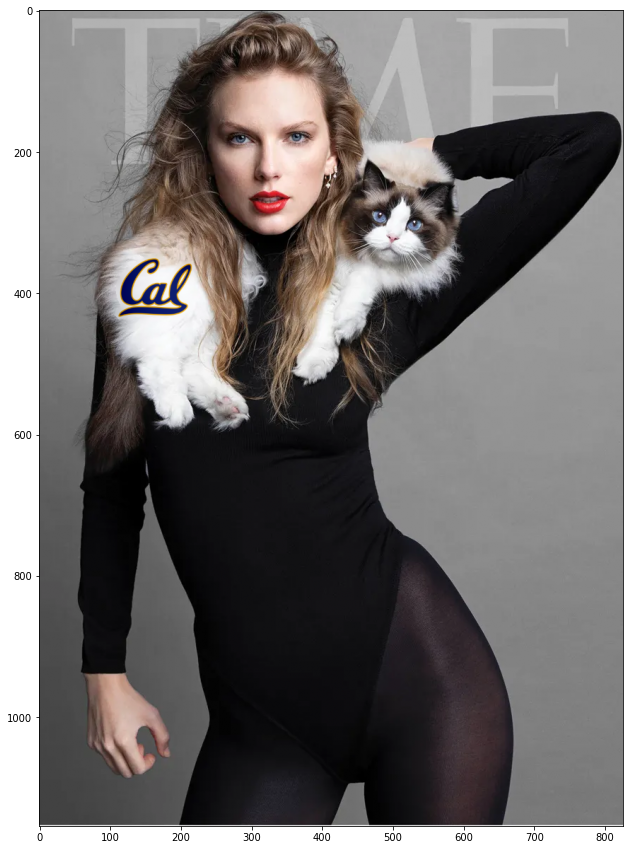

In [72]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)
#plt.savefig("outputs/calcat")

## Part 3 Mixed Gradients (20 pts)

In [33]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img
    """
    assert(len(object_img.shape) == 2), "SINGLE CHANNEL IMAGE ONLY FOR THIS FUNCTION"

    result = bg_img.copy()
    b0, b1 = bg_ul

    im_h, im_w = object_mask.shape
    mask_flat = object_mask.flatten()
    mask_indices = np.where(mask_flat > 0)[0]
    num_values = np.sum(mask_flat)
    num_eq = 2 * num_values
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    A = scipy.sparse.lil_matrix((num_eq, im_h * im_w))
    b = np.zeros((num_eq))
    e = 0

    for i in mask_indices:
        y, x = np.unravel_index(i, (im_h, im_w))
        source = object_img[y, x]
        bg_source = bg_img[y + b0, x + b1]
        neighbors = [(y-1, x), (y, x+1)]

        for n in neighbors:
            yj, xj = n
            d = max([source - object_img[yj, xj], bg_source - bg_img[b0 + yj, b1 + xj]], key = abs)
            A[e, im2var[y, x]] = 1
            if object_mask[yj, xj]:
                A[e, im2var[yj, xj]] = -1                
                b[e] = d
            else:
                b[e] = d + bg_img[b0 + yj, b1 + xj]
            e += 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0][mask_indices]
    mask_idx = np.where(object_mask > 0)
    result[mask_idx[0] + b0, mask_idx[1] + b1] = v

    return result




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


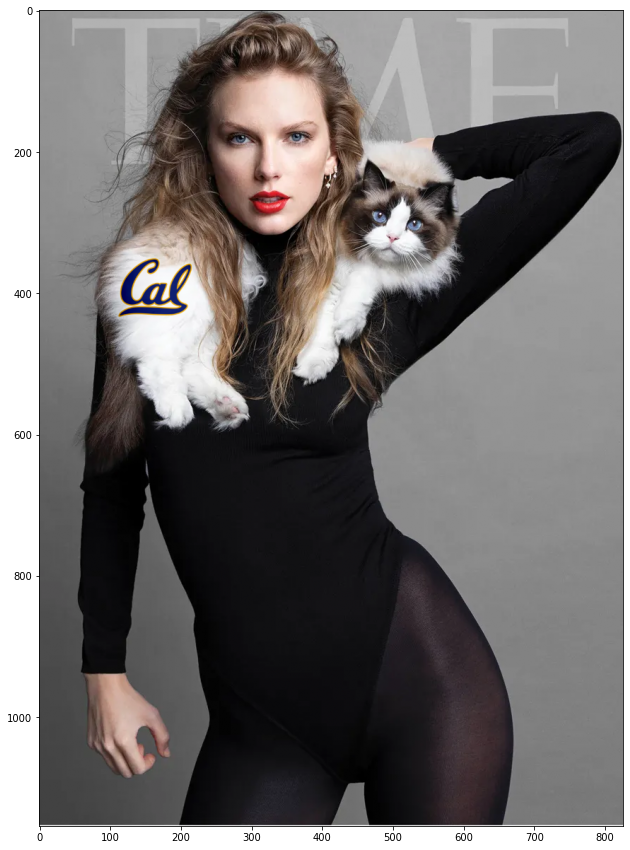

In [74]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)
plt.savefig("../outputs/calcat")

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass